In [4]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter
import dataframe_image as dfi # for saving styled data frame print-out table as png
from duneanalytics import DuneAnalytics 

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 3.5)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [6]:
# set paths and create dirs 
base_dir = '../..'
data_dir = os.path.join(base_dir, 'data')
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
os.makedirs(png_dir, exist_ok=True)

In [7]:
# load helper functions
%run {helper_dir}/plot.py

## Input

In [8]:
chain = 'Arbitrum'

In [9]:
data_fnames = os.listdir(os.path.join(data_dir, chain)) # names of all data files

# collect the names of the files for this analysis
fnames = dict()
for fname in data_fnames:
    if fname.startswith('Fees'):
        fnames['Fees'] = fname
fnames

{'Fees': 'Fees_2021-08-31_2022-07-25.csv'}

In [10]:
# get Dune Analytics login credentials
MY_USERNAME = os.environ.get('DUNE_USERNAME')
MY_PASSWORD = os.environ.get('DUNE_PASSWORD')
dune = DuneAnalytics(MY_USERNAME, MY_PASSWORD)

## Read Fees Data from Stats.GMX

In [11]:
# only read the first 7 cols since the last col "Cumulative" is NOT the daily total, but cumulative daily total, 
# which we don't want.
df_fees = pd.read_csv(os.path.join(data_dir, chain, fnames['Fees']), 
                      parse_dates=['Date'], index_col='Date', usecols=range(6))
df_fees.columns = df_fees.columns.str.lower().str.replace(' ', '_') + '_fees'
# calc daily total 
df_fees['total_fees'] = df_fees.sum(axis=1)
df_fees.head()

,swap_fees,margin_trading_fees,mint_glp_fees,burn_glp_fees,liquidation_fees,total_fees
Date,,,,,,
2021-08-31,0.3993,0.1533,0.1183,0.2062,0.0000,0.8770
2021-09-01,866.3653,101.8488,"4,843.2267",0.0337,0.0000,"5,811.4746"
2021-09-02,854.0028,741.7089,"1,610.5278",134.2650,0.0000,"3,340.5044"
2021-09-03,"1,388.2414","3,127.2669",22.3804,0.0000,0.0000,"4,537.8886"
2021-09-04,219.0247,768.7568,82.8838,0.0000,0.0000,"1,070.6653"


## Read Fees Data from Dune

In [12]:
dune.login()
dune.fetch_auth_token()
 
# fetch query result
result_id = dune.query_result_id(query_id=1091061)
data = dune.query_result(result_id)

# extract the relavent data fields
dd = data['data']['get_result_by_result_id']
df = pd.json_normalize(dd, record_prefix='')
df = df.loc[:, df.columns.str.startswith('data')]
df.columns = df.columns.str.replace('data.', '', regex=False)
df

,day,revenue
0,2021-08-17T00:00:00Z,0.1283
1,2021-08-18T00:00:00Z,0.5490
2,2021-08-19T00:00:00Z,0.1229
3,2021-08-25T00:00:00Z,0.8972
4,2021-08-29T00:00:00Z,0.3729
...,...,...
328,2022-07-19T00:00:00Z,"255,498.8156"
329,2022-07-20T00:00:00Z,"313,746.2196"
330,2022-07-21T00:00:00Z,"166,197.2673"
331,2022-07-22T00:00:00Z,"131,591.5773"


In [13]:
df['date'] = pd.to_datetime(df.day.str.replace('T.*', '', regex=True))
del df['day']
df = df.set_index('date')
df.head()

,revenue
date,
2021-08-17,0.1283
2021-08-18,0.5490
2021-08-19,0.1229
2021-08-25,0.8972
2021-08-29,0.3729


## Compare

In [14]:
dat = pd.merge(df_fees, df, left_index=True, right_index=True)

# drop the last row because the most recent date may not be a full day
# drop the first row because it's the first day and public hasn't started using the platform yet
dat = dat.iloc[1:-1, :]
dat

,swap_fees,margin_trading_fees,mint_glp_fees,burn_glp_fees,liquidation_fees,total_fees,revenue
2021-09-01,866.3653,101.8488,"4,843.2267",0.0337,0.0000,"5,811.4746","5,824.5435"
2021-09-02,854.0028,741.7089,"1,610.5278",134.2650,0.0000,"3,340.5044","3,343.3860"
2021-09-03,"1,388.2414","3,127.2669",22.3804,0.0000,0.0000,"4,537.8886","4,537.9558"
2021-09-04,219.0247,768.7568,82.8838,0.0000,0.0000,"1,070.6653","1,070.8960"
2021-09-05,277.1210,784.1034,106.0886,0.0000,0.0000,"1,167.3130","1,167.6274"
...,...,...,...,...,...,...,...
2022-07-18,"44,499.0965","267,658.4198","4,414.4588",564.4718,"6,071.6036","323,208.0505","323,226.2140"
2022-07-19,"29,560.7320","217,367.6741","1,820.5122","2,961.5648","3,779.1920","255,489.6751","255,498.8156"
2022-07-20,"26,023.6861","225,092.0442","3,714.4787","43,760.6059","15,165.5741","313,756.3889","313,746.2196"
2022-07-21,"19,796.5991","122,289.3743","4,277.2546","19,556.8365",272.2835,"166,192.3481","166,197.2673"


In [15]:
# a = dat.swap_fees+dat.mint_glp_fees+dat.burn_glp_fees
# a = dat.margin_trading_fees + dat.liquidation_fees
a = dat.total_fees
b = dat.revenue
res = a - b
res

2021-09-01   -13.0690
2021-09-02    -2.8816
2021-09-03    -0.0672
2021-09-04    -0.2307
2021-09-05    -0.3144
               ...   
2022-07-18   -18.1635
2022-07-19    -9.1405
2022-07-20    10.1694
2022-07-21    -4.9192
2022-07-22    12.3049
Length: 325, dtype: float64

In [16]:
print(res.min(), res.max())

-391.515217426233 180.84698040946387


In [17]:
print(res.mean())

-19.23685857829931


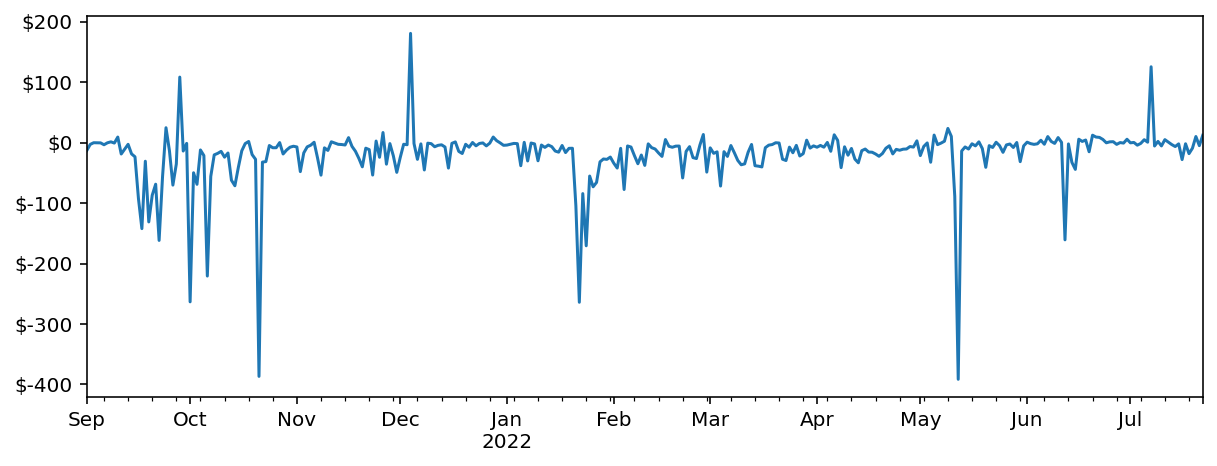

In [18]:
ax = res.plot()
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)

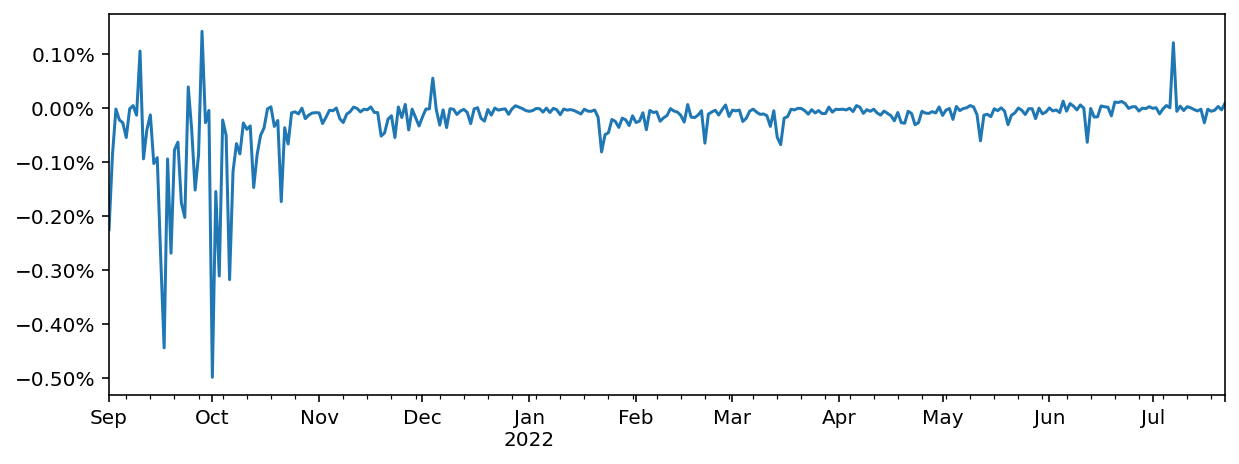

In [19]:
base = (a + b)/2
pct_diff = res / base # should be very small
ax = pct_diff.plot()
ax.yaxis.set_major_formatter(PercentFormatter(1))